In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import cv2
from collections import OrderedDict
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
dataDir='/data1/deng'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
cuda = torch.device("cuda")

In [4]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
accessory electronic vehicle food sports person appliance outdoor kitchen furniture indoor animal


In [6]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['dog']);
imgIds = coco.getImgIds(catIds=catIds);
# imgIds = coco.getImgIds(imgIds = [324158])
imgs = coco.loadImgs(imgIds)
img = imgs[np.random.randint(0, len(imgs))]

In [7]:
img

{'license': 3,
 'file_name': '000000209613.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000209613.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-16 12:31:34',
 'flickr_url': 'http://farm9.staticflickr.com/8417/8858921356_8fbedafbd0_z.jpg',
 'id': 209613}

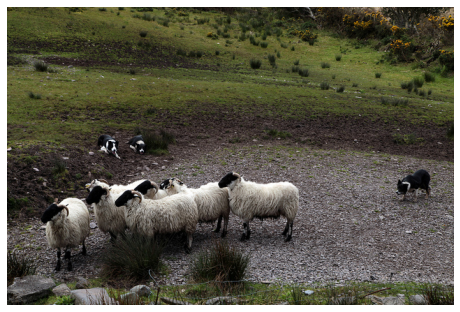

In [8]:
I = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

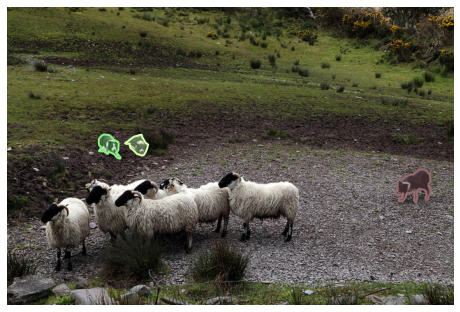

In [9]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

Little experiment with cv2 resize and scikit image rescale

In [10]:
I = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

In [11]:
resized = cv2.resize(I, (640, 640))
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
target = coco.annToMask(anns[0])

In [12]:
width, height = 128, 128

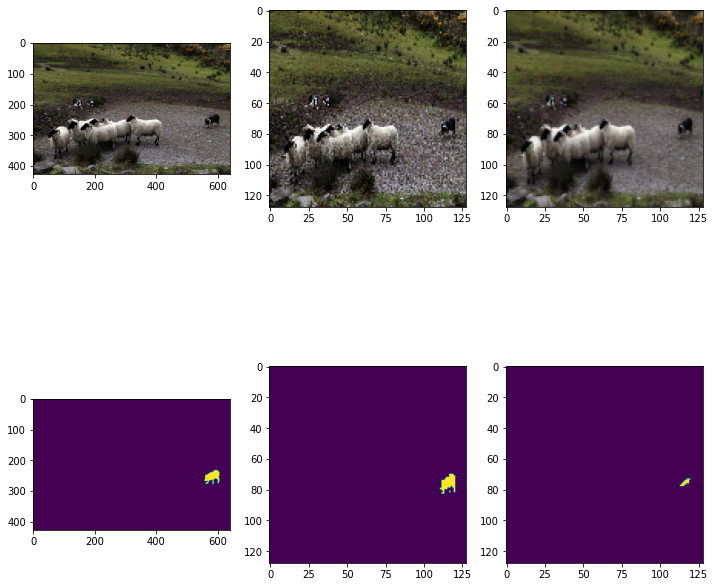

In [13]:
f, axarr = plt.subplots(2,3, figsize=(12, 12))
axarr[0,0].imshow(I)
axarr[0,1].imshow(cv2.resize(I, (width, height)))
axarr[0,2].imshow(resize(I, (width, height), anti_aliasing = True))
# f, axarr = plt.subplots(1,3, figsize=(12, 12))
axarr[1,0].imshow(target)
axarr[1,1].imshow(cv2.resize(target, (width, height)))
axarr[1,2].imshow(resize(target, (width, height), anti_aliasing = True))

Generate Dataset

In [14]:
class COCODataset(Dataset):
    def __init__(self, dataType, width = 256, height = 256, cat = "dog"):
        dataDir='/data1/deng'
#         dataType='val2017'
        annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
        coco=COCO(annFile)
        catIds = coco.getCatIds(catNms=[cat]);
        imgIds = coco.getImgIds(catIds=catIds);
        imgs = coco.loadImgs(imgIds)
        # get image
        self.data = []
        self.targets = []
        self.empty_resized_target = []
        self.weird_dimension = []
        # Find maximum size for resizing
#         max_h, max_w = 0,0
#         for img in imgs:
#             max_h, max_w = max(img['height'], max_h), max(img['width'], max_w)
        max_h, max_w = width, height
        # append after resizing and transposing
        for img in imgs:
            I = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
            I = cv2.resize(I, (max_h, max_w))
            if len(I.shape) == 3:
                I = np.transpose(I, (2,0,1))
                self.data.append(I)
            else:
                self.weird_dimension.append(img)
                continue
            
            
            annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
            anns = coco.loadAnns(annIds)
            target = coco.annToMask(anns[0])
            target = cv2.resize(target, (max_h, max_w))
            # skimage's resize doesn't work!!! generates emtpy target images
#             target = resize(target, (max_h, max_h))
            if target.sum() == 0:
                self.empty_resized_target.append(img)
            self.targets.append(target)
        if len(self.empty_resized_target) == 0:
            print("No empty target")
        else:
            print("Empty target resulted from resizing, number:(", len(self.empty_resized_target),")")
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]
    
    def __len__(self):
        return len(self.data)

In [15]:
val_dataset = COCODataset("val2017", width, height, "dog")

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
No empty target


In [16]:
train_dataset = COCODataset("train2017", width, height, "dog")

loading annotations into memory...
Done (t=20.58s)
creating index...
index created!
No empty target


In [17]:
len(train_dataset.weird_dimension)

10

In [18]:
# for img in dataset.empty_resized_target:
#     plt.imshow(img)
#     plt.show()

In [19]:
train_dl = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_dl = DataLoader(val_dataset, batch_size = 128, shuffle = False)

In [20]:
d, l = train_dataset[1]
d.shape, l.shape

((3, 128, 128), (128, 128))

Replicate UNet

In [21]:
class UNet(nn.Module):
    # Define blocks
    def get_encoding_block(self, in_channels, out_channels, kernel_size=3, padding = 0):
        """
        This function creates one encoding block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding = padding),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding = padding),
            torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
        )
        return block
    
    def get_decoding_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding = 0):
        """
        This function creates one expansive block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = padding),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding = padding),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        return  block
        
    def get_final_block(self, in_channels, mid_channels, out_channels, kernel_size = 3, padding = 0):
        block = nn.Sequential(
            nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channels, padding = padding),
            nn.ReLU(),
            nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channels, out_channels = mid_channels, padding = padding),
            nn.ReLU(),
            nn.Conv2d(kernel_size = 1, in_channels = mid_channels, out_channels = out_channels)
        )
        return block
    
    def __init__(self):
        super(UNet, self).__init__()
        # Encode
        self.en1 = self.get_encoding_block(3, 64, 5, 2)
        self.max1 = nn.MaxPool2d(kernel_size=2)
        self.en2 = self.get_encoding_block(64, 128, 5, 2)
        self.max2 = nn.MaxPool2d(kernel_size=2)
        self.en3 = self.get_encoding_block(128, 256, 5, 2)
        self.max3 = nn.MaxPool2d(kernel_size=2)
        self.en4 = self.get_encoding_block(256, 512, 5, 2)
        self.max4 = nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bt = self.get_decoding_block(512, 1024, 512, 5, 2)
        # Decode
        self.de4 = self.get_decoding_block(1024, 512, 256, 5, 2)
        self.de3 = self.get_decoding_block(512, 256, 128, 5, 2)
        self.de2 = self.get_decoding_block(256, 128, 64, 5, 2)
        self.de1 = self.get_final_block(128, 64, 2, 1)
        
        # for predicting
        self.sf = nn.Softmax(dim = 1)
    
    def forward(self, x, test = False):
        # Encode
        en1 = self.en1(x)
        x = self.max1(en1)
        en2 = self.en2(x)
        x = self.max2(en2)
        en3 = self.en3(x)
        x = self.max3(en3)
        en4 = self.en4(x)
        x = self.max4(en4)
        # Bottleneck
        x = self.bt(x)
        # Decode
        x = torch.cat((x, en4), 1)
        x = self.de4(x)
        x = torch.cat((x, en3), 1)
        x = self.de3(x)
        x = torch.cat((x, en2), 1)
        x = self.de2(x)
        x = torch.cat((x, en1), 1)
        x = self.de1(x)
        if test:
            x = self.sf(x)
        return x

Training?

In [22]:
model = UNet()
model.to(device = torch.device("cuda"))
summary(model, train_dataset[0][0].shape)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.99)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        4,864
|    └─ReLU: 2-2                         [-1, 64, 128, 128]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 128, 128]        128
|    └─Conv2d: 2-4                       [-1, 64, 128, 128]        102,464
|    └─ReLU: 2-5                         [-1, 64, 128, 128]        --
|    └─BatchNorm2d: 2-6                  [-1, 64, 128, 128]        128
├─MaxPool2d: 1-2                         [-1, 64, 64, 64]          --
├─Sequential: 1-3                        [-1, 128, 64, 64]         --
|    └─Conv2d: 2-7                       [-1, 128, 64, 64]         204,928
|    └─ReLU: 2-8                         [-1, 128, 64, 64]         --
|    └─BatchNorm2d: 2-9                  [-1, 128, 64, 64]         256
|    └─Conv2d: 2-10                      [-1, 128, 64, 64]         40

/home/deng/venv/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [23]:
def train(epochs, report_per_epoch = 1):
    for epoch in range(epochs):
        training_loss = 0
        for _, (I, tar) in enumerate(train_dl):
            I = I.to(device = cuda)
            tar = tar.to(device = cuda)
            segmented = model(I.float())
            loss = criterion(segmented, tar.long())
            training_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(epoch, training_loss.cpu().detach().numpy() / len(train_dl))
        if (epoch + 1) % report_per_epoch == 0:
            with torch.no_grad():
                validation_loss = 0
                for _, (I, tar) in enumerate(valid_dl):
                    I = I.to(device = cuda)
                    tar = tar.to(device = cuda)
                    segmented = model(I.float())
                    validation_loss += criterion(segmented, tar.long())
            print(epoch, validation_loss.cpu().detach().numpy() / len(valid_dl))
#             break
#         break
%time train(10,2)

0 0.4056118674900221


KeyboardInterrupt: 

In [ ]:
records = []
n
with torch.no_grad():
    for _, (I, tar) in enumerate(valid_dl):
        I = I.to(device = cuda)
        tar = tar.to(device = cuda)
        segmented = model.sf(model(I.float()))
        records.append([I.cpu().detach().numpy(), tar.cpu().detach().numpy(), segmented.cpu().detach().numpy()])

In [ ]:
tar.shape

In [ ]:
i = np.random.randint(0, len(records[0][0]))
f, axarr = plt.subplots(1,3, figsize=(12, 12))
axarr[0].imshow(np.transpose(records[0][0][i], (1,2,0)))
axarr[1].imshow(records[0][1][i])
axarr[2].imshow(np.argmax(records[0][2][i], axis=0))